# Tartan Data Science Cup

In [1]:
import pandas as pd
import numpy as np
import operator

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder

from keras.utils.np_utils import to_categorical

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Using Theano backend.


# Data Prep
    - binarize the target column : 'loan_status'

In [2]:
# load data
data = pd.read_csv('../input/train.csv')
tst  = pd.read_csv('../input/test.csv')

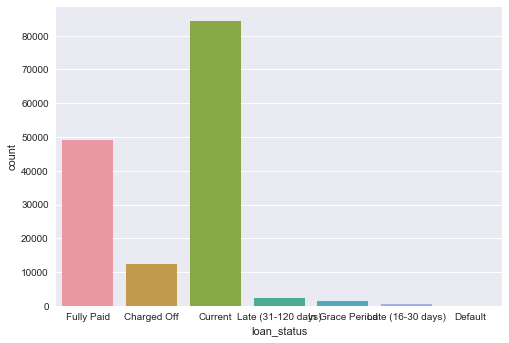

In [3]:
# check loan_status histogram

sns.countplot(data['loan_status'])

In [4]:
# convert 'loan_status' into binary

col = 'loan_status'
positives = ['Fully Paid','Current','In Grace Period']
y = np.zeros(data.shape[0])

for i, row in enumerate(data[col]):
    if row not in positives:
        y[i] = 1    
        
print('# Ratio of positives : {}% out of 150k'.format((y.sum()/y.shape)[0]))

# Ratio of positives : 0.10142666666666666% out of 150k


# Feature Engineering
    - converting categorical variables into numeric variables
    - extracting information from feature interactions

### did not use
    - emp_title, url, desc, title
    
### ideas
    - zip_code may need improvement via clustering/dividing by city/rural
    - use loan_amnt - funded_amnt/_inv

In [ ]:
# check object dtypes

for col in data.columns:
    if data[col].dtypes == 'O':
        print('# col {} \t\t| nuniq {}'.format(col, len(data[col].unique())))

In [5]:
# converting categorical variables into numeric
features = []

# term
col = 'term'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# int_rate
col = 'int_rate'
data[col] = data[col].apply(lambda x: x[:-1]).astype(np.float32)
tst[col] = tst[col].apply(lambda x: x[:-1]).astype(np.float32)
features.append(col)

# grade
col = 'grade'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# sub_grade
col = 'sub_grade'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# emp_length
col = 'emp_length'
temp = data[col].apply(lambda x: x[:2])
temp.replace('n/', 0, inplace=True)
temp.replace('< ', 0.5, inplace=True)
data[col] = temp.astype(np.float32)
temp = tst[col].apply(lambda x: x[:2])
temp.replace('n/', 0, inplace=True)
temp.replace('< ', 0.5, inplace=True)
tst[col] = temp.astype(np.float32)
features.append(col)

# home_ownership
col = 'home_ownership'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# verification_status
col = 'verification_status'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)


# issue_d
col = 'issue_d'
months_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
              'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10,'Nov':11,'Dec':12}
data['issue_m'] = data[col].apply(lambda x: months_map[x[:3]])
tst['issue_m'] = tst[col].apply(lambda x: months_map[x[:3]])
features.append('issue_m')

data['issue_y'] = data[col].apply(lambda x: x[4:]).astype(np.int32)
tst['issue_y'] = tst[col].apply(lambda x: x[4:]).astype(np.int32)
features.append('issue_y')

# purpose
col = 'purpose'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# zip_code
col = 'zip_code'
lb = LabelEncoder()
lb.fit(pd.concat([data[col], tst[col]], axis=0))
data[col] = lb.transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# addr_state
col = 'addr_state'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# earliest_cr_line
col = 'earliest_cr_line'
data['earliest_cr_line_m'] = data[col].apply(lambda x: months_map[x[:3]])
tst['earliest_cr_line_m'] = tst[col].apply(lambda x: months_map[x[:3]])
features.append('earliest_cr_line_m')

data['earliest_cr_line_y'] = data[col].apply(lambda x: x[4:]).astype(np.int32)
tst['earliest_cr_line_y'] = tst[col].apply(lambda x: x[4:]).astype(np.int32)
features.append('earliest_cr_line_y')

# revol_util
col = 'revol_util'
data[col] = data[col].apply(lambda x: str(x).replace('%','')).astype(np.float32).fillna(0)
tst[col] = tst[col].apply(lambda x: str(x).replace('%','')).astype(np.float32).fillna(0)
features.append(col)

# initial_list_status
col = 'initial_list_status'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# application_type
col = 'application_type'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)


In [6]:
# additional feature engineering

# distance from today to issue_d and early_cr_line
data['issue_datestamp'] = ((2017 - 1900)*12 + 2) - (data['issue_m'] + (data['issue_y'] - 1900)*12)
data['early_cr_datestamp'] = ((2017 - 1900)*12 + 2) - (data['earliest_cr_line_m'] + (data['earliest_cr_line_y'] - 1990)*12)
tst['issue_datestamp'] = ((2017 - 1900)*12 + 2) - (tst['issue_m'] + (tst['issue_y'] - 1900)*12)
tst['early_cr_datestamp'] = ((2017 - 1900)*12 + 2) - (tst['earliest_cr_line_m'] + (tst['earliest_cr_line_y'] - 1990)*12)
features.append('issue_datestamp')
features.append('early_cr_datestamp')

# loan_funded_amount
col = 'loan_funded_amount'
data[col] = data['loan_amnt'] - data['funded_amnt']
# features.append(col)

# fund_inv_ratio
col = 'fund_inv_ratio'
data[col] =data['funded_amnt_inv'] / data['funded_amnt']
data[col].fillna(1, inplace=True)
# features.append('fund_inv_ratio')

In [7]:
# outliers

def to_bin(x):
    if x < 10000: return 1
    elif x < 30000: return 2
    elif x < 60000: return 3
    elif x < 90000: return 4
    elif x < 120000: return 5
    else: return 6

# annual_inc in bin
col = 'annual_inc'
data['annual_inc_bin'] = data[col].apply(lambda x: to_bin(x))
tst['annual_inc_bin'] = tst[col].apply(lambda x: to_bin(x))
features.append('annual_inc_bin')

# dti clip > 99 to 100
data.loc[data['dti'] > 99, 'dti'] = 100
tst.loc[tst['dti'] > 99, 'dti'] = 100

# pub_rec clipt >20 to 20
data.loc[data['pub_rec'] > 20,'pub_rec'] = 20
tst.loc[tst['pub_rec'] > 20,'pub_rec'] = 20

In [ ]:
data.ix[0]

In [ ]:
data.iloc[777]

In [ ]:
tst.iloc[777]

# Model Evlauation
    - Evaluting base model with k-fold cross-validation

In [8]:
# benchmark evaluation values for Brier scores to refer

# all zero
bench_m = np.zeros(data.shape[0])
print('# All Zero')
print('\tBrier   : {0:.4f}'.format(brier_score_loss(y, bench_m)))
print('\tAUC     : {0:.4f}'.format(roc_auc_score(y, bench_m)))
print('\tLogloss : {0:.4f}\n'.format(log_loss(y, bench_m)))

# all 0.5
bench_m += 0.5
print('# All 0.5')
print('\tBrier   : {0:.4f}'.format(brier_score_loss(y, bench_m)))
print('\tAUC     : {0:.4f}'.format(roc_auc_score(y, bench_m)))
print('\tLogloss : {0:.4f}\n'.format(log_loss(y, bench_m)))

# all 1.0
bench_m += 0.5
print('# All One')
print('\tBrier   : {0:.4f}'.format(brier_score_loss(y, bench_m)))
print('\tAUC     : {0:.4f}'.format(roc_auc_score(y, bench_m)))
print('\tLogloss : {0:.4f}\n'.format(log_loss(y, bench_m)))

# All Zero
	Brier   : 0.1014
	AUC     : 0.5000
	Logloss : 3.5032

# All 0.5
	Brier   : 0.2500
	AUC     : 0.5000
	Logloss : 0.6931

# All One
	Brier   : 0.8986
	AUC     : 0.5000
	Logloss : 31.0363



In [9]:
features.extend(['loan_amnt', 'installment', 'annual_inc', 'dti' ,'delinq_2yrs', 'inq_last_6mths', 'open_acc',
            'pub_rec', 'total_acc'])
print(len(features))

29


In [10]:
trn = data.as_matrix(columns=features)

trn_bri = []; vld_bri = []
trn_auc = []; vld_auc = []
trn_log = []; vld_log = []

skf = StratifiedKFold(n_splits=3)
for trn_index, vld_index in skf.split(trn, y):
    
    # split data into trn/vld
    x_trn, x_vld = trn[trn_index], trn[vld_index]
    y_trn, y_vld = y[trn_index], y[vld_index]
    
    # model fit
    model = RandomForestClassifier(max_depth=10, 
                                  n_jobs=-1, random_state=777)
    '''
    model = RandomForestClassifier(max_depth=5, 
                                  n_jobs=-1, random_state=777)
    model = LogisticRegression(C=10, n_jobs=-1)
    '''
    #model = LogisticRegression(C=1, n_jobs=-1)
    model.fit(x_trn, y_trn)

    # trn scores
    trn_pred = model.predict_proba(x_trn)[:,1]
    trn_bri.append(brier_score_loss(y_trn, trn_pred))
    trn_auc.append(roc_auc_score(y_trn, trn_pred))
    trn_log.append(log_loss(y_trn, trn_pred))
    
    # vld scores
    vld_pred = model.predict_proba(x_vld)[:,1]
    vld_bri.append(brier_score_loss(y_vld, vld_pred))
    vld_auc.append(roc_auc_score(y_vld, vld_pred))
    vld_log.append(log_loss(y_vld, vld_pred))
    
print('=' * 50)
print(' TRAIN')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(trn_bri), np.std(trn_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(trn_auc), np.std(trn_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(trn_log), np.std(trn_log)))

print('=' * 50)
print(' VALID')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(vld_bri), np.std(vld_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(vld_auc), np.std(vld_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(vld_log), np.std(vld_log)))

 TRAIN
--------------------------------------------------
# Brier   : 0.0780 + 0.08
# AUC     : 0.8161 + 0.82
# Logloss : 0.2680 + 0.27
 VALID
--------------------------------------------------
# Brier   : 0.0855 + 0.09
# AUC     : 0.7290 + 0.73
# Logloss : 0.2973 + 0.30


[Brier]
05 | 0.0860 | 0.0863
10 | 0.0822 | 0.0854
20 | 0.0289 | 0.0895

[AUC]
05 | 0.7286 | 0.7215
10 | 0.7693 | 0.7299
20 | 0.9982 | 0.6900

In [ ]:
# single data observation
data.loc[777,features]

# XGBoost modeling

In [11]:
trn = data.as_matrix(columns=features)

trn_bri = []; vld_bri = []
trn_auc = []; vld_auc = []
trn_log = []; vld_log = []

param = {
        'objective': 'binary:logistic',
        'eta': 0.02,
        'min_child_weight': 10,
        'max_depth': 5,
        'silent': 1,
        'eval_metric': 'auc',
        'colsample_bytree': 0.8,
        'colsample_bylevel': 0.8,
    }

best_ntree = []
skf = StratifiedKFold(n_splits=3)
for trn_index, vld_index in skf.split(trn, y):
    
    # split data into trn/vld
    x_trn, x_vld = trn[trn_index], trn[vld_index]
    y_trn, y_vld = y[trn_index], y[vld_index]
    
    dtrn = xgb.DMatrix(x_trn, label=y_trn, feature_names=features)
    dvld = xgb.DMatrix(x_vld, label=y_vld, feature_names=features)
    
    evallist  = [(dtrn,'train'), (dvld,'eval')]
    model = xgb.train(param, dtrn, 1000, evals=evallist, early_stopping_rounds=20)    
    
    best_ntree_limit = model.best_ntree_limit
    best_ntree.append(best_ntree_limit)
    
    # trn scores
    trn_pred = model.predict(dtrn)
    trn_bri.append(brier_score_loss(y_trn, trn_pred))
    trn_auc.append(roc_auc_score(y_trn, trn_pred))
    trn_log.append(log_loss(y_trn, trn_pred))
    
    # vld scores
    vld_pred = model.predict(dvld)
    vld_bri.append(brier_score_loss(y_vld, vld_pred))
    vld_auc.append(roc_auc_score(y_vld, vld_pred))
    vld_log.append(log_loss(y_vld, vld_pred))
    
print('=' * 50)
print(' TRAIN')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(trn_bri), np.std(trn_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(trn_auc), np.std(trn_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(trn_log), np.std(trn_log)))

print('=' * 50)
print(' VALID')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(vld_bri), np.std(vld_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(vld_auc), np.std(vld_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(vld_log), np.std(vld_log)))

[0]	train-auc:0.733048	eval-auc:0.729978
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.73614	eval-auc:0.731921
[2]	train-auc:0.738371	eval-auc:0.733851
[3]	train-auc:0.738494	eval-auc:0.733798
[4]	train-auc:0.738619	eval-auc:0.734444
[5]	train-auc:0.739448	eval-auc:0.734829
[6]	train-auc:0.739557	eval-auc:0.734948
[7]	train-auc:0.739586	eval-auc:0.734919
[8]	train-auc:0.739826	eval-auc:0.734816
[9]	train-auc:0.740078	eval-auc:0.735275
[10]	train-auc:0.740184	eval-auc:0.735361
[11]	train-auc:0.740066	eval-auc:0.73502
[12]	train-auc:0.740267	eval-auc:0.73521
[13]	train-auc:0.740248	eval-auc:0.735314
[14]	train-auc:0.740693	eval-auc:0.735759
[15]	train-auc:0.740697	eval-auc:0.735705
[16]	train-auc:0.740823	eval-auc:0.735859
[17]	train-auc:0.740889	eval-auc:0.736045
[18]	train-auc:0.740972	eval-auc:0.73604
[19]	train-auc:0.741135	eval-auc:0.736028
[20]	train-auc:0.741208	eval-auc:

[Brier]
param_2 | 0.0819 | 0.0844

[AUC]
param_2 | 0.7752 | 0.7432

# feature importance_tree

In [ ]:
print('='*50)
print(model)

feature_importance = dict()
for i, f_imp in enumerate(model.feature_importances_):
    feature_importance[features[i]] = f_imp

print('-'*50)
print('# Sorted Feature Importance')
feature_importance_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
prefix = '    '
for item in feature_importance_sorted:
    print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))

# plot
fimp = feature_importance_sorted
plot_x = []; plot_y = []
for item in fimp:
    plot_x.append(item[0])
    plot_y.append(item[1])

f, ax = plt.subplots(figsize=(20, 15))
sns.barplot(plot_x,plot_y,alpha=0.5)
ax.set_title('Feature Importance for Model : RandomForest Tree')
ax.set(xlabel='Column Name', ylabel='Feature Importance')

# Feature importance_linear

In [ ]:
prefix = '    '

In [ ]:
target_num = 0
print('='*50)
print(model)

print('='*50)
print('# Coefficients for target_num == {}'.format(target_num))
print(model.coef_[target_num])

feature_importance = dict()
for i, f_imp in enumerate(model.coef_[target_num]):
    feature_importance[features[i]] = f_imp

print('-'*50)
print('# Sorted Feature Importance')
coefs_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
for item in coefs_sorted:
    print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))

plot_x = []; plot_y = []
for item in coefs_sorted:
    plot_x.append(item[0])
    plot_y.append(item[1])

f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(plot_x,plot_y,alpha=0.5)
ax.set_title('Feature Importance for Model : Logistic Regression')
ax.set(xlabel='Column Name', ylabel='Feature Importance')

In [ ]:
model.get_fscore()

# Feature importance_xgboost

In [ ]:
import operator

print('='*50)

print('-'*50)
print('# Sorted Feature Importance')
feature_importance_sorted = sorted(model.get_fscore().items(), key=operator.itemgetter(1), reverse=True)
prefix = '    '
for item in feature_importance_sorted:
    print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))

# plot
fimp = feature_importance_sorted
plot_x = []; plot_y = []
for item in fimp:
    plot_x.append(item[0])
    plot_y.append(item[1])

f, ax = plt.subplots(figsize=(20, 15))
sns.barplot(plot_x,plot_y,alpha=0.5)
ax.set_title('Feature Importance for Model : XGBoost Tree')
ax.set(xlabel='Column Name', ylabel='Feature Importance')

# outlier detection
    - feature wise histogram to see the spread and detect outlier

In [ ]:
for feature in features:
    print('# Col : {}'.format(feature))
    sns.distplot(data[feature], kde=False)
    plt.show()

In [ ]:
# single data observation
data.loc[122]

# Making submission

In [ ]:
# fit all data
model.fit(trn, y)

# make prediction on test
prediction = model.predict_proba(tst.as_matrix(columns=features))[:,1]

# output to file
submission = pd.DataFrame(prediction, columns=['prediction'])
filename = '../output/anything_random_valid_{0:.4f}.csv'.format(np.mean(vld_bri))
submission.to_csv(filename, index=False)

In [12]:
# fit all data

dtrn = xgb.DMatrix(data.as_matrix(columns=features), label=y, feature_names=features)
model = xgb.train(param, dtrn, int(np.mean(best_ntree)*1.5))
    
# make prediction on test
dtst = xgb.DMatrix(tst.as_matrix(columns=features), feature_names=features)
prediction = model.predict(dtst)

# output to file
submission = pd.DataFrame(prediction, columns=['prediction'])
filename = '../output/anything_random_valid_{0:.4f}.csv'.format(np.mean(vld_bri))
submission.to_csv(filename, index=False)

In [ ]:
submission.shape

# train-valid-test relationship

In [ ]:
skf = StratifiedKFold(n_splits=3)
for trn_index, vld_index in skf.split(trn, y):
    pass
    
for col in features:
    print('='*50)
    print('col : ', col)

    trn_tmp = pd.DataFrame(data.ix[trn_index, col])
    vld_tmp = pd.DataFrame(data.ix[vld_index, col])
    tst_tmp = pd.DataFrame(tst[col])
    trn_tmp['state'] = 'trn'
    vld_tmp['state'] = 'vld'
    tst_tmp['state'] = 'tst'
    tmp = pd.concat([trn_tmp, vld_tmp, tst_tmp], axis=0)

    sns.violinplot(x="state", y=col, data=tmp)
    plt.show()